<a href="https://colab.research.google.com/github/hktimmana/first-cat/blob/master/tl_vgg16_Breakhis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
from google.colab import drive
drive.mount('/content/gdrive')
#github access token ='e2058c653da64e011154ccfb80b2aff54276a744'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [90]:
IMG_DIM = (150, 150)

train_files = glob.glob('/content/gdrive/My Drive/research/final/**/train/**/*.png')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[-2].strip() for fn in train_files]

validation_files = glob.glob('/content/gdrive/My Drive/research/final/**/val/**/*.png')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[-2].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape,validation_labels)

Train dataset shape: (5523, 150, 150, 3) 	Validation dataset shape: (1570, 150, 150, 3) ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC

(150, 150, 3)


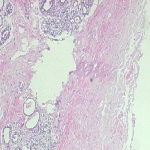

In [91]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [93]:
batch_size = 30
num_classes = 8
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


label_encoder = LabelEncoder()
train_encoded = label_encoder.fit_transform(train_labels)
onehot_encoder = OneHotEncoder(sparse=False)
train_encoded = train_encoded.reshape(len(train_encoded), 1)
train_labels_enc = onehot_encoder.fit_transform(train_encoded)
valid_encoded = label_encoder.fit_transform(validation_labels)
valid_encoded = valid_encoded.reshape(len(valid_encoded), 1)
validation_labels_enc = onehot_encoder.fit_transform(valid_encoded)
print(train_labels[100:111], train_labels_enc[100:111])

['DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC', 'DC'] [[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]


In [94]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers
import tensorflow as tf
from keras import backend as K
#from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(tf.distribute.cluster_resolver.TPUClusterResolver())
# initialize our CancerNet model and compile it
with strategy.scope():  
  model = Sequential(name='BiherNet')

  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                  input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(8, activation='softmax'))
  model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(),
                metrics=['accuracy'])

  model.summary()

INFO:tensorflow:Initializing the TPU system: grpc://10.6.43.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.43.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "BiherNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 15, 15, 128)       147

In [95]:
epochs = 100
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='accuracy', mode='max', patience=100, verbose=2)
model_checkpoint = ModelCheckpoint('/content/gdrive/My Drive/research/model/tl_base_model_full.h5', save_best_only=True, verbose=2)
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[early_stopping, model_checkpoint])
model.save('/content/gdrive/My Drive/research/model/tl_base_model_after_full.h5')

Train on 5523 samples, validate on 1570 samples
Epoch 1/100
5523/5523 [==============================] - 36s 7ms/step - loss: 0.3258 - accuracy: 0.8817 - val_loss: 0.3303 - val_accuracy: 0.8725

Epoch 00001: val_loss improved from inf to 0.33028, saving model to /content/gdrive/My Drive/research/model/tl_base_model_full.h5
Epoch 2/100
5523/5523 [==============================] - 36s 6ms/step - loss: 0.2964 - accuracy: 0.8902 - val_loss: 0.2859 - val_accuracy: 0.8971

Epoch 00002: val_loss improved from 0.33028 to 0.28591, saving model to /content/gdrive/My Drive/research/model/tl_base_model_full.h5
Epoch 3/100
5523/5523 [==============================] - 36s 6ms/step - loss: 0.2897 - accuracy: 0.8933 - val_loss: 0.2705 - val_accuracy: 0.9009

Epoch 00003: val_loss improved from 0.28591 to 0.27047, saving model to /content/gdrive/My Drive/research/model/tl_base_model_full.h5
Epoch 4/100
5523/5523 [==============================] - 35s 6ms/step - loss: 0.2837 - accuracy: 0.8944 - val_los

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['MC', 'MC', 'MC', 'MC', 'MC']


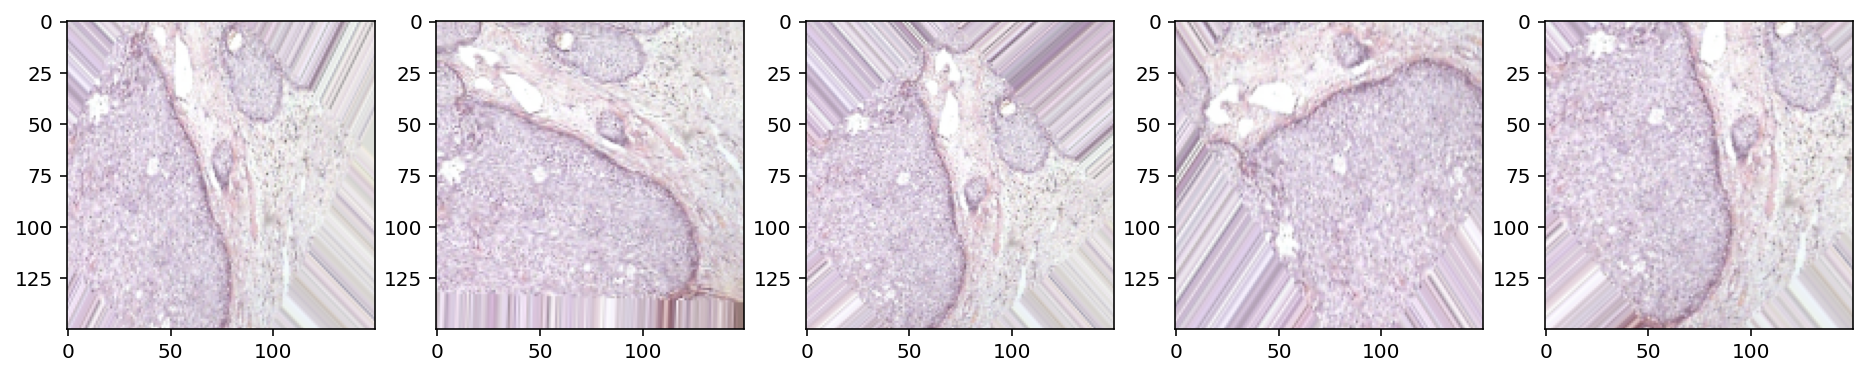

In [97]:
img_id = 1111
mc_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
mc = [next(mc_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in mc])
l = [ax[i].imshow(mc[i][0][0]) for i in range(0,5)]

Labels: ['A', 'A', 'A', 'A', 'A']


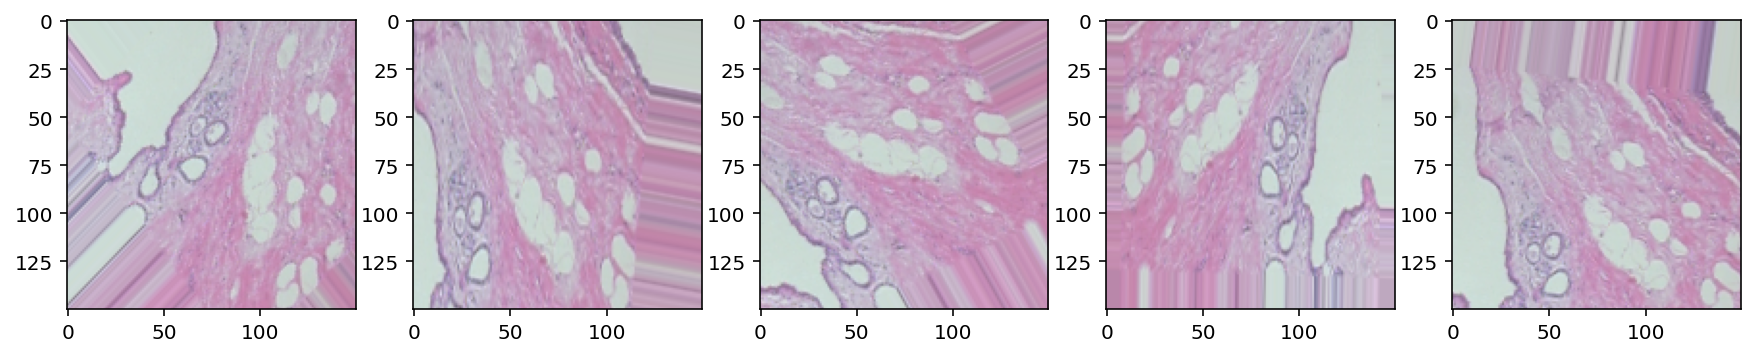

In [98]:
img_id = 10
a_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
a= [next(a_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in a])
l = [ax[i].imshow(a[i][0][0]) for i in range(0,5)]

In [99]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)
input_shape = (150, 150, 3)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers
with strategy.scope():  
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                    input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='softmax'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['accuracy'])
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='accuracy', mode='max', patience=100, verbose=2)
model_checkpoint = ModelCheckpoint('/content/gdrive/My Drive/research/model/tl_base_model_aug_full.h5', save_best_only=True, verbose=2)              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1,callbacks=[early_stopping, model_checkpoint]) 

Epoch 1/100
100/100 [==============================] - 22s 221ms/step - loss: 0.3223 - accuracy: 0.8804 - val_loss: 0.3422 - val_accuracy: 0.8892

Epoch 00001: val_loss improved from inf to 0.34220, saving model to /content/gdrive/My Drive/research/model/tl_base_model_aug_full.h5
Epoch 2/100
100/100 [==============================] - 21s 207ms/step - loss: 0.3157 - accuracy: 0.8845 - val_loss: 0.3081 - val_accuracy: 0.8886

Epoch 00002: val_loss improved from 0.34220 to 0.30814, saving model to /content/gdrive/My Drive/research/model/tl_base_model_aug_full.h5
Epoch 3/100
100/100 [==============================] - 20s 205ms/step - loss: 0.2964 - accuracy: 0.8893 - val_loss: 0.3289 - val_accuracy: 0.8870

Epoch 00003: val_loss did not improve from 0.30814
Epoch 4/100
100/100 [==============================] - 21s 206ms/step - loss: 0.3044 - accuracy: 0.8853 - val_loss: 0.2574 - val_accuracy: 0.8883

Epoch 00004: val_loss improved from 0.30814 to 0.25744, saving model to /content/gdrive/M

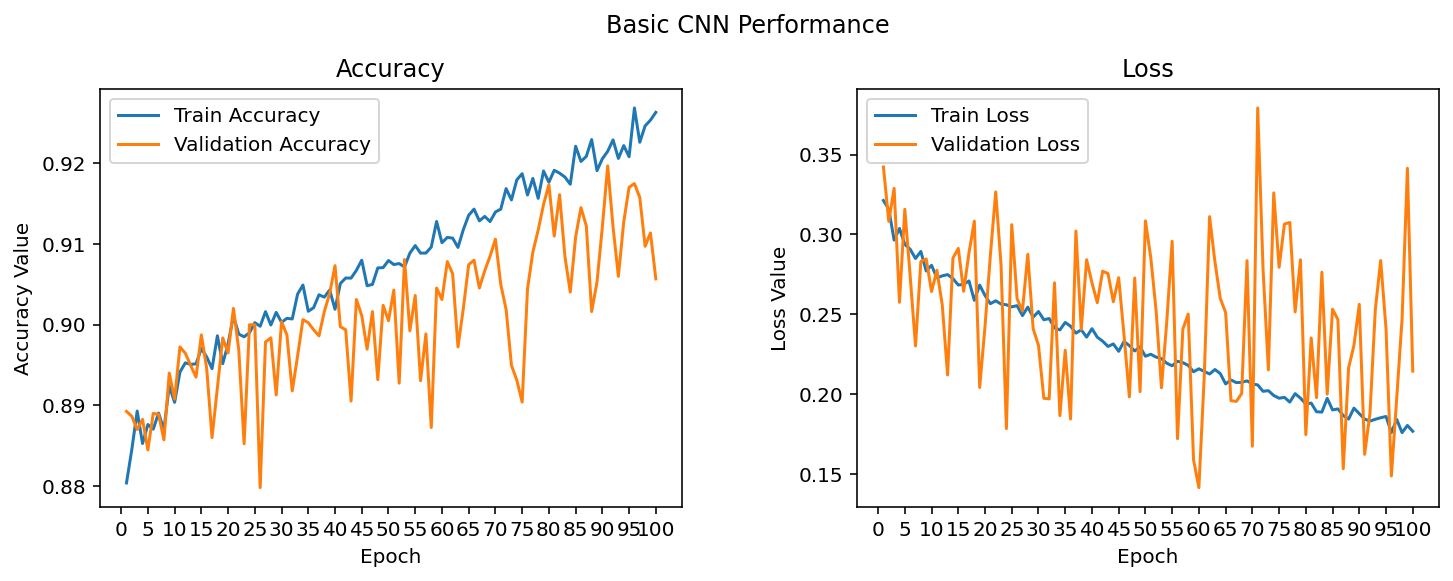

In [102]:
def plot_Training(history):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  t = f.suptitle('Basic CNN Performance', fontsize=12)
  f.subplots_adjust(top=0.85, wspace=0.3)

  epoch_list = list(range(1,101))
  ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
  ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
  ax1.set_xticks(np.arange(0, 101, 5))
  ax1.set_ylabel('Accuracy Value')
  ax1.set_xlabel('Epoch')
  ax1.set_title('Accuracy')
  l1 = ax1.legend(loc="best")

  ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
  ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
  ax2.set_xticks(np.arange(0, 101, 5))
  ax2.set_ylabel('Loss Value')
  ax2.set_xlabel('Epoch')
  ax2.set_title('Loss')
  l2 = ax2.legend(loc="best")

plot_Training(history)

Leveraging Transfer Learning with Pre-trained CNN Models


Pre-trained CNN model as a Feature Extractor

In [103]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fecf3af5ba8>,input_6,False
1,<keras.layers.convolutional.Conv2D object at 0x7fecf3af5208>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7fecf1037be0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7fecfa3b7cc0>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7fecfa3b7048>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7feceeb048d0>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7fed3cb7f668>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7fed3cb7f0f0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7fed3cb85b38>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7fecf1838be0>,block3_conv3,False


(1, 4, 4, 512)


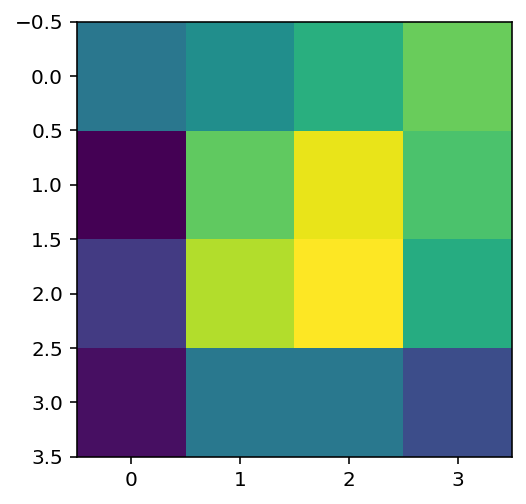

In [104]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [105]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (5523, 8192) 	Validation Bottleneck Features: (1570, 8192)


In [106]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
with strategy.scope():  
  input_shape = vgg_model.output_shape[1]

  model = Sequential()
  model.add(InputLayer(input_shape=(input_shape,)))
  model.add(Dense(512, activation='relu', input_dim=input_shape))
  model.add(Dropout(0.3))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(8, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_39 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_40 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 8)                 4104      
Total params: 4,461,576
Trainable params: 4,461,576
Non-trainable params: 0
_________________________________________________________________


In [107]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='accuracy', mode='max', patience=20, verbose=2)
model_checkpoint = ModelCheckpoint('/content/gdrive/My Drive/research/model/tl_base_model_tl_full.h5', save_best_only=True, verbose=2)
history1 = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[early_stopping, model_checkpoint]) 


Train on 5523 samples, validate on 1570 samples
Epoch 1/100
5523/5523 [==============================] - 10s 2ms/step - loss: 0.3190 - accuracy: 0.8809 - val_loss: 0.3181 - val_accuracy: 0.8803

Epoch 00001: val_loss improved from inf to 0.31812, saving model to /content/gdrive/My Drive/research/model/tl_base_model_tl_full.h5
Epoch 2/100
5523/5523 [==============================] - 9s 2ms/step - loss: 0.2857 - accuracy: 0.8905 - val_loss: 0.3002 - val_accuracy: 0.8830

Epoch 00002: val_loss improved from 0.31812 to 0.30021, saving model to /content/gdrive/My Drive/research/model/tl_base_model_tl_full.h5
Epoch 3/100
5523/5523 [==============================] - 10s 2ms/step - loss: 0.2645 - accuracy: 0.8976 - val_loss: 0.2636 - val_accuracy: 0.8975

Epoch 00003: val_loss improved from 0.30021 to 0.26361, saving model to /content/gdrive/My Drive/research/model/tl_base_model_tl_full.h5
Epoch 4/100
5523/5523 [==============================] - 10s 2ms/step - loss: 0.2492 - accuracy: 0.9038 -

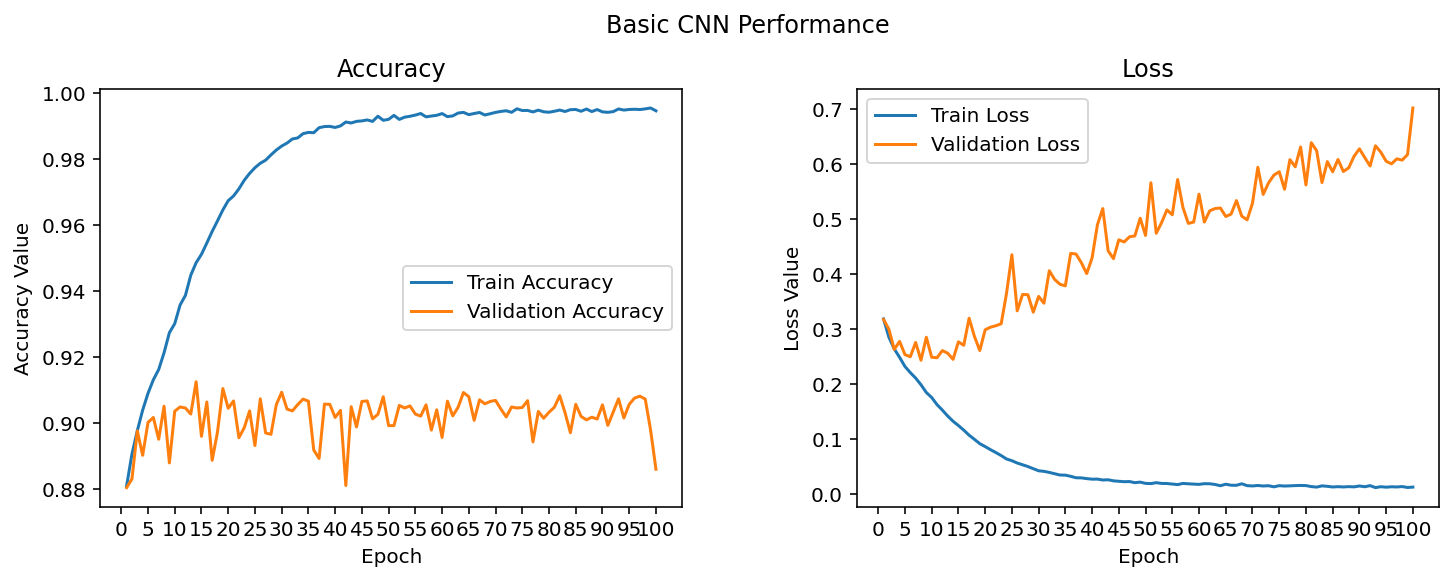

In [108]:
plot_Training(history1)

Pre-trained CNN model as a Feature Extractor with Image Augmentation


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [0]:

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
with strategy.scope(): 
  model = Sequential()
  model.add(vgg_model)
  model.add(Dense(512, activation='relu', input_dim=input_shape))
  model.add(Dropout(0.3))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(8, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='accuracy', mode='max', patience=100, verbose=2)
model_checkpoint = ModelCheckpoint('/content/gdrive/My Drive/research/model/tl_model_cnn_aug_full.h5', save_best_only=True, verbose=2)
              
history2 = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1,callbacks=[early_stopping, model_checkpoint])   

Epoch 1/100
100/100 [==============================] - 33s 325ms/step - loss: 0.3430 - accuracy: 0.8728 - val_loss: 0.2950 - val_accuracy: 0.8781

Epoch 00001: val_loss improved from inf to 0.29502, saving model to /content/gdrive/My Drive/research/model/tl_model_cnn_aug_full.h5
Epoch 2/100
100/100 [==============================] - 32s 320ms/step - loss: 0.3276 - accuracy: 0.8764 - val_loss: 0.2747 - val_accuracy: 0.8814

Epoch 00002: val_loss improved from 0.29502 to 0.27465, saving model to /content/gdrive/My Drive/research/model/tl_model_cnn_aug_full.h5
Epoch 3/100
100/100 [==============================] - 32s 319ms/step - loss: 0.3203 - accuracy: 0.8799 - val_loss: 0.3290 - val_accuracy: 0.8904

Epoch 00003: val_loss did not improve from 0.27465
Epoch 4/100
100/100 [==============================] - 32s 316ms/step - loss: 0.3135 - accuracy: 0.8821 - val_loss: 0.2858 - val_accuracy: 0.8856

Epoch 00004: val_loss did not improve from 0.27465
Epoch 5/100
100/100 [===================

In [0]:
plot_Training(history2)

Pre-trained CNN model with Fine-tuning and Image Augmentation

In [0]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
with strategy.scope(): 
  model = Sequential()
  model.add(vgg_model)
  model.add(Dense(512, activation='relu', input_dim=input_shape))
  model.add(Dropout(0.3))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(8, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='accuracy', mode='max', patience=100, verbose=2)
model_checkpoint = ModelCheckpoint('/content/gdrive/My Drive/research/model/tl_fine_cnn_aug_full.h5', save_best_only=True, verbose=2)
              
history3 = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1,callbacks=[early_stopping, model_checkpoint])   

In [0]:
plot_Training(history3)

Evaluating our Deep Learning Models on Test Data

In [0]:
# load dependencies
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu
%matplotlib inline

# load saved models
basic_cnn = load_model('tl_base_model_full.h5')
img_aug_cnn = load_model('tl_base_model_aug_full.h5')
tl_cnn = load_model('tl_base_model_tl_full.h5')
tl_img_aug_cnn = load_model('tl_model_cnn_aug_full.h5')
tl_img_aug_finetune_cnn = load_model('tl_fine_cnn_aug_full.h5')

# load other configurations
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
#num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
#class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]
def class2num_label_transformer(lables):
  return LabelEncoder().fit_transform(labels)
def num2class_label_transformer(lablels):
  return LabelEncoder().inverse_transform(labels)
# load VGG model for bottleneck features
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [0]:
IMG_DIM = (150, 150)

test_files = glob.glob('/content/gdrive/My Drive/research/final/**/train/**/*.png')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[-2].strip() for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255
test_labels_enc = class2num_label_transformer(test_labels)

print('Test dataset shape:', test_imgs.shape)
print(test_labels[0:5], test_labels_enc[0:5])

Model 1: Basic CNN Performance

In [0]:
predictions = basic_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model 2: Basic CNN with Image Augmentation Performance

In [0]:
predictions = img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model 3: Transfer Learning — Pre-trained CNN as a Feature Extractor Performance

In [0]:
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)

predictions = tl_cnn.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model 4: Transfer Learning — Pre-trained CNN as a Feature Extractor with Image Augmentation Performance

In [0]:
predictions = tl_img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model 5: Transfer Learning — Pre-trained CNN with Fine-tuning and Image Augmentation Performance

In [0]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

In [0]:
# worst model - basic CNN 
meu.plot_model_roc_curve(basic_cnn, test_imgs_scaled, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1]) 

# best model - transfer learning with fine-tuning & image augmentation 
meu.plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1])

In [0]:
!ls -l /content/gdrive/My\ Drive/research/model/

total 1069719
-rw------- 1 root root   9745592 May  5 09:26 base_cnn.h5
-rw------- 1 root root   9745536 May  6 03:34 base_cnn_model.h5
-rw------- 1 root root   9745536 May  6 04:10 base_cnn_model_sgd.h5
-rw------- 1 root root   4881936 May  6 03:40 base_cnn_weights0.h5
-rw------- 1 root root   4881920 May  6 02:30 base_cnn_weights1.h5
-rw------- 1 root root   4881928 May  6 03:12 base_cnn_weights2.h5
-rw------- 1 root root   4881920 May  6 02:09 base_cnn_weights.h5
-rw------- 1 root root   4881936 May  6 04:16 base_cnn_weights_sgd.h5
-rw------- 1 root root  10002272 May  5 04:53 BiherNet_combine.model
-rw------- 1 root root   5021472 May  5 04:58 BiherNet_weight_1.h5
-rw------- 1 root root  45613184 May  5 07:32 bottleneck_features_train.npy
-rw------- 1 root root  12583040 May  5 07:32 bottleneck_features_validation.npy
-rw------- 1 root root      5700 May  5 07:31 bottleneck_labels_train.npy
-rw------- 1 root root      1708 May  5 07:32 bottleneck_labels_validation.npy
-rw------- 1 